### Декомпозиция
Задача: Обработать массив данных и сформировать модель монетизации игрового приложения.

1. Изучить данные
2. Предобработка данных
3. Исследовательский анализ данных:
    1) Оценить имеющийся запас средств на рекламу(потраченные средства уже на рекламу)
    2) Сравнить способы завершения уровня
    3) Выявить источники рекламы(потенциально сравнить с затраченными средствами + выявить прибыльные источники)
    4) Другие графики для большей наглядности
4. Проанализировать влияние событий на совершение целевого события(завершит уровень или нет) [как будто бы это тоже исследовательский анализ данных]
5. Проверить статистические гипотезы 
6. Описание и оценка новой модели монетизации(указать степень окупаемости)
Проверить гипотезу различия времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.

Сформулировать и проверить статистическую гипотезу относительно представленных данных

Проверить гипотезу различия времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.

### Описание данных
Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Датасет *game_actions.csv*:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи.

Датасет *ad_costs.csv* содержит колонки:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет user_source.csv содержит колонки:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st
import numpy as np

In [3]:
pd.set_option('display.max_columns', 50) 
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_colwidth', False)
# параметры для корректного отображения таблиц и более удобного их анализа

In [5]:
# функция для отображения часто используемых запросов
def info(df):
    display(df.head())
    display(df.info())
    display(df.isna().sum())
    display(df.duplicated().sum())

In [6]:
info(game_actions)

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


None

event_datetime    0     
event             0     
building_type     7683  
user_id           0     
project_type      133774
dtype: int64

1

Значения дат в формате object --> заменить на datetime <br>
Один дубликат. В таком большом датасете можно не разбираться и сразу его удалить

In [7]:
info(ad_costs)

,source,day,cost
0,facebook_ads,2020-05-03,935.88279
1,facebook_ads,2020-05-04,548.35448
2,facebook_ads,2020-05-05,260.18575
3,facebook_ads,2020-05-06,177.98220
4,facebook_ads,2020-05-07,111.76680


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


None

source    0
day       0
cost      0
dtype: int64

0

Значения дат в формате object  --> заменить на datetime

In [8]:
info(user_source)

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


None

user_id    0
source     0
dtype: int64

0

###  Предобработка данных

In [9]:
# избавляемся от одного дубликата
game_actions = game_actions.drop_duplicates().reset_index()

In [10]:
# переводим столбец с датой и временем в тип datetime
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
# добавляем столбец только с датой
game_actions['event_dt'] = pd.to_datetime(game_actions['event_datetime']).dt.date

In [11]:
# переводим столбец с датой и временем в тип datetime
ad_costs['day'] = pd.to_datetime(ad_costs['day'])

При изучении датасетов можно увидеть, что если project_type заполнено, то в столбце event будет project. Также, если в столбце event указано building, то в building_type будет тип здания, если указано 'finished_stage_1' или 'project', то будет пропуск

In [12]:
game_actions['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

In [14]:
game_actions['event'].unique()

array(['building', 'finished_stage_1', 'project'], dtype=object)

In [20]:
game_actions['building_type'].unique()

array(['assembly_shop', 'spaceport', nan, 'research_center'], dtype=object)

In [15]:
# проверяем, есть ли ошибки, если event = building
check1 = game_actions.query("event=='building'")
check1['building_type'].unique()

array(['assembly_shop', 'spaceport', 'research_center'], dtype=object)

In [18]:
# проверяем, есть ли ошибки, если project_type = 'satellite_orbital_assembly
check2 = game_actions.query("project_type=='satellite_orbital_assembly'")
print(check2['event'].unique())
print(check2['building_type'].unique())

['project']
[nan]


Ошибок и пропусков не обнаружено

### Исследовательский анализ данных

In [21]:
game_actions['event'].value_counts()

building            127956
finished_stage_1    5817  
project             1866  
Name: event, dtype: int64

Зданий строят много, чтобы завершить уровень

In [22]:
game_actions['building_type'].value_counts()

spaceport          59325
assembly_shop      54494
research_center    14137
Name: building_type, dtype: int64

Здания первого и второго типа строят в одинаковых количествах. Исследовательский центр строят намного реже, возможно стоит дороже

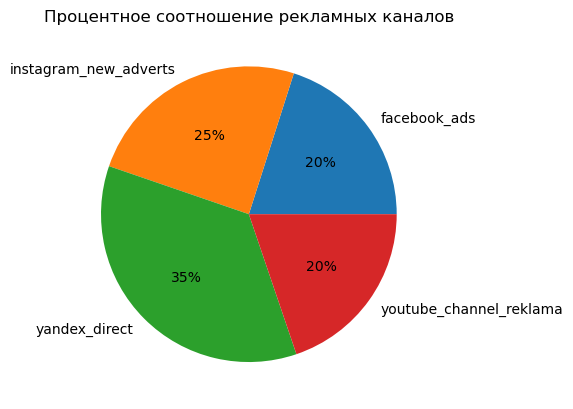

In [23]:
source = user_source.groupby('source', as_index=False).count()
plt.pie(source['user_id'], labels=source['source'], autopct='%.0f%%')
plt.title('Процентное соотношение рекламных каналов');

Немного посмотреть на рекламные каналы, откуда приходят пользователи. Примерно равные доли по 4 источникам. Яндекс выделяется 35% пользователей. Скорее всего игра ориентирована на жителей СНГ.

При уточнении задачи было сказано не углубляться в источники, поэтому данный график присутствует только для общего ознакомления с данными. Возможно, это поможет в будущем для анализа (как мне, так и другим командам). Например при изучении этнических и социальных особенностей при выборе рынка сбыта

#### Изучение влияния событий на завершение уровня

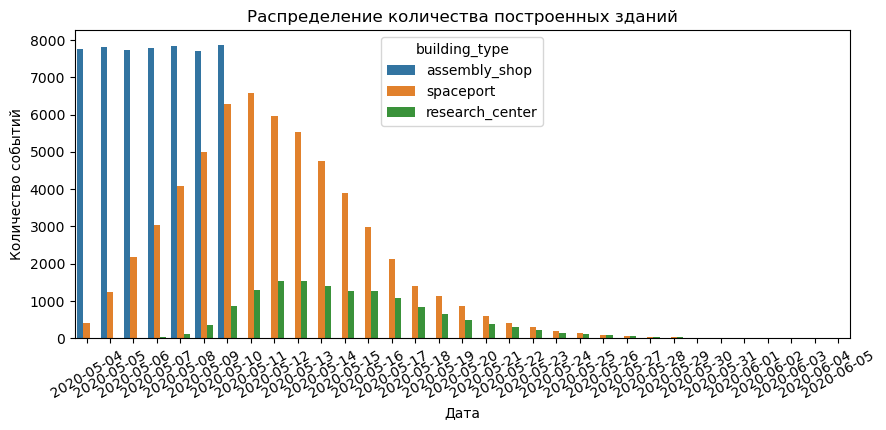

In [24]:
building_per_day = game_actions.groupby(['event_dt', 'building_type'], as_index=False)[['user_id']].count()
plt.figure(figsize=(10,4))
sns.barplot(data=building_per_day, x='event_dt', y='user_id', errorbar=None, hue='building_type')
plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Распределение количества построенных зданий');

По графику распределения построек для всех пользователей сразу отмечается то, что assembly_shop строят в равных долях все с 4 по 10 мая(дни привлечения), следовательно это стартовая постройка, которая скорее всего строится на этапе обучения(сразу при запуске). <br>
Дальше видим поднимается значение количества построек spaceport с задержкой относительно первого типа. Возможно требуется накопить определенное количество ресурсов и по достижении этой отметки приходит пуш-уведомление --> пользователь заходит второй раз в игру. <br>
Значения research_center сильно ниже первых двух типов строений, скорее всего стоят они дорого и потенциально долго строятся, что не интересно большинству пользователей ввиду того, что нужно ждать.

In [25]:
# создаем таблицу с пользователями, которые прошли уровень
o = game_actions[game_actions['event'] == 'finished_stage_1']['user_id']
completed_lvl = game_actions.merge(o, how='inner')

# создаем таблицу с пользователями, которые не прошли уровень
didnt_finish = pd.merge(game_actions, completed_lvl, how='outer', indicator=True)
didnt_finish = didnt_finish.loc[didnt_finish['_merge'] == 'left_only'].drop('_merge', axis=1)

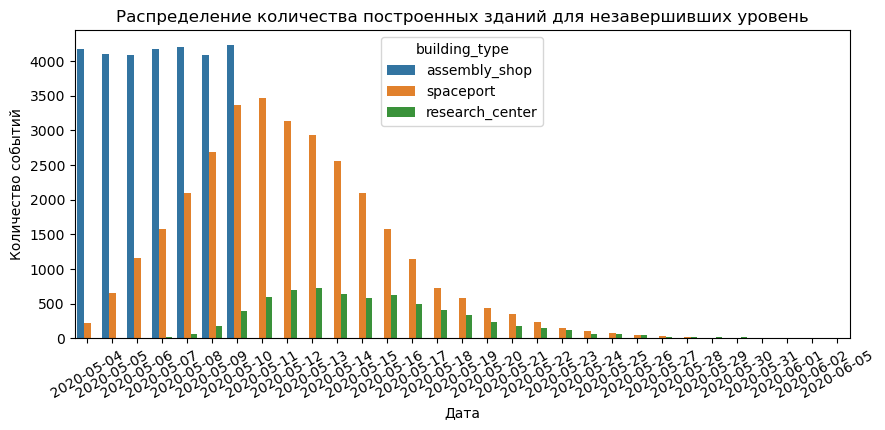

In [26]:
building_didnt_finish = didnt_finish.groupby(['event_dt', 'building_type'], as_index=False)[['user_id']].count()
plt.figure(figsize=(10,4))
sns.barplot(data=building_didnt_finish, x='event_dt', y='user_id', errorbar=None, hue='building_type')
plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Распределение количества построенных зданий для незавершивших уровень');

Практически все пользователи строят первый тип зданий в день привлечения

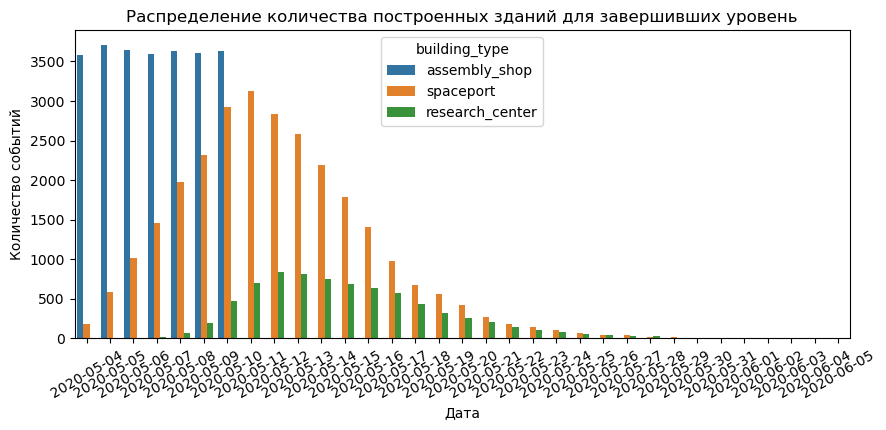

In [27]:
building_completed = completed_lvl.groupby(['event_dt', 'building_type'], as_index=False)[['user_id']].count()
plt.figure(figsize=(10,4))
sns.barplot(data=building_completed, x='event_dt', y='user_id', errorbar=None, hue='building_type')
plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Распределение количества построенных зданий для завершивших уровень');

Аналогично, первому графику, практически все пользователи строят первый тип зданий в день привлечения

При сравнении графиков, визуализирующих распределение количества построенных зданий для завершивших и не завершивших уровень пользователей можно выявить пару закономерностей:
* График незавершивших пользователей более растянутый, чем у завершивших --> те, кто завершает уровень, делают постройки быстрее, чем не завершающие
* Завершившие уровень строят больше построек типа research_center

In [28]:
i = completed_lvl.query("building_type == 'research_center'")
f"Количество уникальных игроков, построивших хотя бы один research_center: {i['user_id'].nunique()}"

'Количество уникальных игроков, построивших хотя бы один research_center: 4208'

Не все пользователи, которые закончили уровень построили хотя бы один research_center, следовательно можно закончить уровень с начальными постройками

#### Изучение среднего времени нахождения пользователей в игре

In [29]:
# создаем столбец с временем нахождения пользователей в игре от первого до последнего действия

# найдем дату первой и последней активности
first_action = game_actions.sort_values(by=['event_dt','user_id']).groupby('user_id')['event_dt'].first()
last_action = game_actions.sort_values(by=['event_dt','user_id']).groupby('user_id')['event_dt'].last()
# присоеденим к общей таблице
game_actions = game_actions.merge(first_action, on='user_id', how='left') 
game_actions = game_actions.merge(last_action, on='user_id', how='left') 
#перееименуем столбцы
game_actions = game_actions.rename(columns={'event_dt_x':'date', 'event_dt_y':'first_date', 'event_dt':'last_date'})
# переводим в формат даты
game_actions['last_date'] = pd.to_datetime(game_actions['last_date'], errors='coerce')
game_actions['first_date'] = pd.to_datetime(game_actions['first_date'], errors='coerce')
# находим количество дней
game_actions['lifetime'] = (game_actions['last_date'] - game_actions['first_date']).dt.days

In [30]:
# перезаписываем таблицу с пользователями, которые прошли уровень с добавлением времени нахождения пользователей в игре
o = game_actions[game_actions['event'] == 'finished_stage_1']['user_id']
completed_lvl = game_actions.merge(o, how='inner')

# перезаписываем таблицу с пользователями, которые не прошли уровень с добавлением времени нахождения пользователей в игре
didnt_finish = pd.merge(game_actions, completed_lvl, how='outer', indicator=True)
didnt_finish = didnt_finish.loc[didnt_finish['_merge'] == 'left_only'].drop('_merge', axis=1)

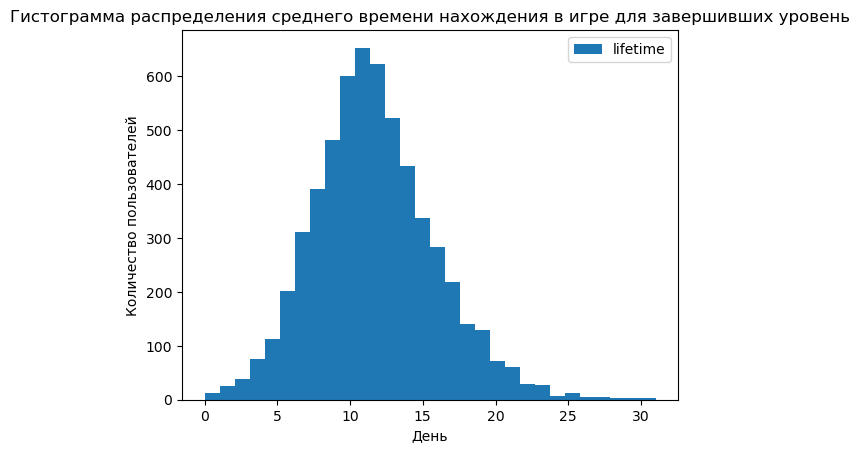

In [31]:
completed_lvl.pivot_table(index='user_id', values='lifetime').plot(kind='hist', bins=30, title='Гистограмма распределения среднего времени нахождения в игре для завершивших уровень')
plt.xlabel('День')
plt.ylabel('Количество пользователей');

Большинство пользователей проходят уровень за 10-13 дней независимо от способа завершения

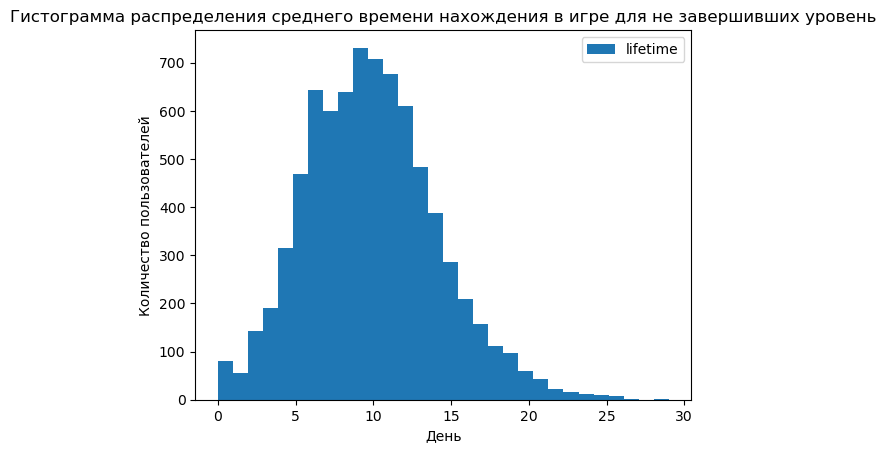

In [32]:
didnt_finish.pivot_table(index='user_id', values='lifetime').plot(kind= 'hist', bins=30, title='Гистограмма распределения среднего времени нахождения в игре для не завершивших уровень')
plt.xlabel('День')
plt.ylabel('Количество пользователей');

Большинство пользователей, которые так и не прошли уровень, заканчивали играть в диапазоне от 5 до 14 дней с первой постройки

In [33]:
# узнаем количество пользователей, которые закончили уровень через завершение постройки базы
pve = game_actions.query("event == 'project'")
pve.count()

index             1866
event_datetime    1866
event             1866
building_type     0   
user_id           1866
project_type      1866
date              1866
first_date        1866
last_date         1866
lifetime          1866
dtype: int64

In [34]:
# приводим дату к виду без времени для графика
pve['last_date'] = pve['last_date'].dt.strftime('%Y-%m-%d')
pve.count()

C:\Users\parol\AppData\Local\Temp\ipykernel_10952\496967505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pve['last_date'] = pve['last_date'].dt.strftime('%Y-%m-%d')


index             1866
event_datetime    1866
event             1866
building_type     0   
user_id           1866
project_type      1866
date              1866
first_date        1866
last_date         1866
lifetime          1866
dtype: int64

In [35]:
# узнаем количество пользователей, которые закончили уровень через победу над противником
game_actions.loc[(~game_actions['user_id'].isin(game_actions[game_actions['event'] == 'project']['user_id'])) & (game_actions['event'] == 'finished_stage_1'), 'project_type'] = 'pvp_win'
pvp = game_actions.query("project_type == 'pvp_win'")
pvp.count()

index             3951
event_datetime    3951
event             3951
building_type     0   
user_id           3951
project_type      3951
date              3951
first_date        3951
last_date         3951
lifetime          3951
dtype: int64

In [36]:
# приводим дату к виду без времени для графика
pvp['last_date'] = pvp['last_date'].dt.strftime('%Y-%m-%d')
pvp.count()

C:\Users\parol\AppData\Local\Temp\ipykernel_10952\3322084251.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pvp['last_date'] = pvp['last_date'].dt.strftime('%Y-%m-%d')


index             3951
event_datetime    3951
event             3951
building_type     0   
user_id           3951
project_type      3951
date              3951
first_date        3951
last_date         3951
lifetime          3951
dtype: int64

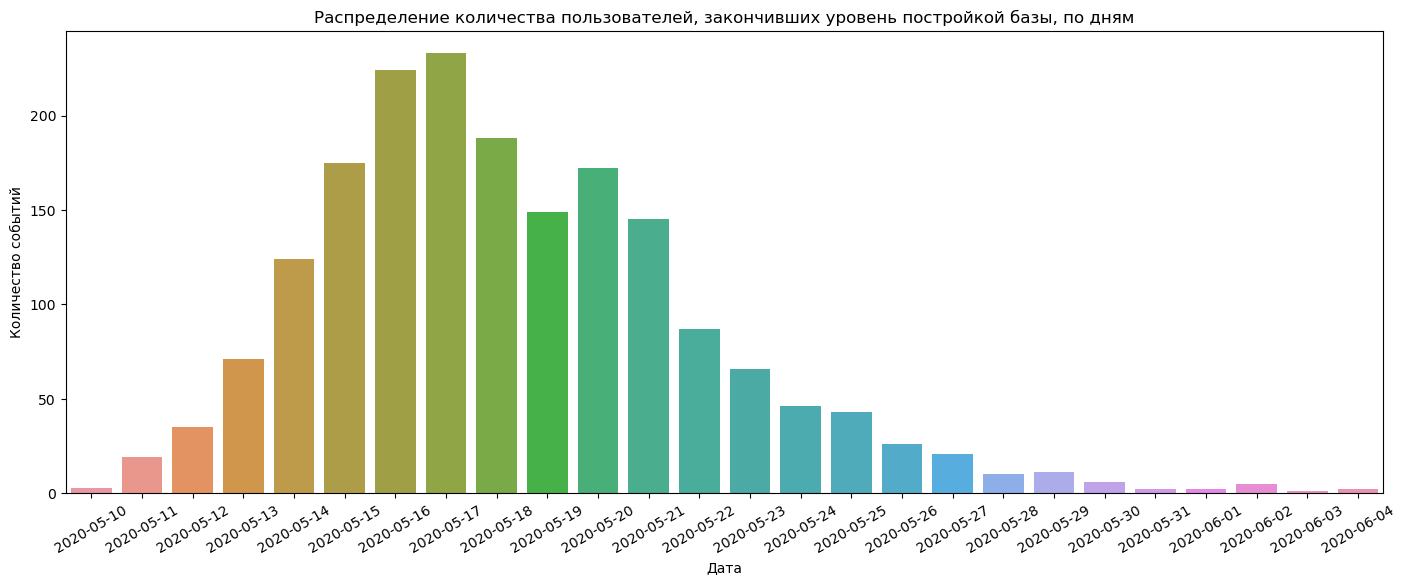

In [37]:
finish_pve = pve.groupby(['last_date'], as_index=False)[['user_id']].count()
plt.figure(figsize=(17,6))
sns.barplot(data=finish_pve, x='last_date', y='user_id', errorbar=None)
plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Распределение количества пользователей, закончивших уровень постройкой базы, по дням');

Большинство пользователей, которые строят базу, заканчивают уровень с 6 по 9 дни. <br>
Есть небольшой всплеск на 11-12 дне, что может являться вторым малым пиком завершения уровня. Скорее всего, это те, кто строились через третью постройку research_center<br>

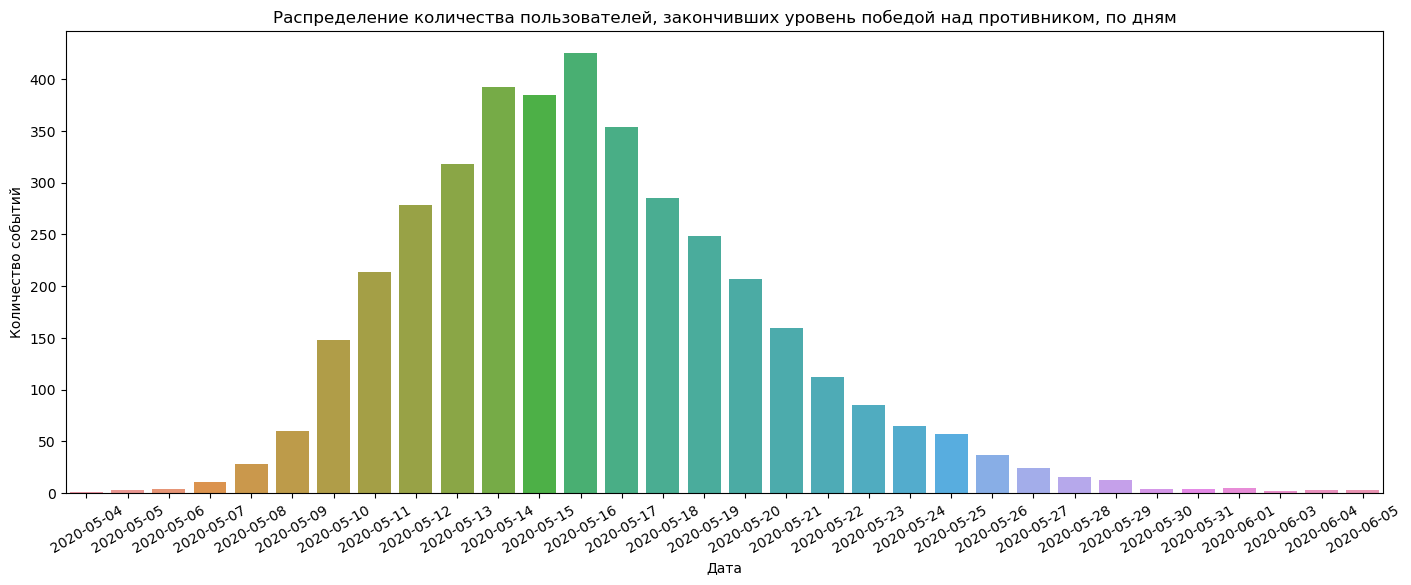

In [38]:
finish_pvp = pvp.groupby(['last_date'], as_index=False)[['user_id']].count()
plt.figure(figsize=(17,6))
sns.barplot(data=finish_pvp, x='last_date', y='user_id', errorbar=None)
plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Распределение количества пользователей, закончивших уровень победой над противником, по дням');

Распределение пользователей, кто закончил уровень победой над противником стремится к нормальному. Имеется один большой пик и большинство распределилось вокруг него. Пик пользователей пришелся на 10 по 15 дни с первого события.

Игроки, выбирающие стратегию победы над противником заканчивают уровень в среднем позже, чем те, кто идет через постройку базы

### Изучение рекламы

In [54]:
ingame_ad_cost = 0.07
sum_ads = ad_costs['cost'].sum() / ingame_ad_cost
f'Количество рекламы, которое требуется показать для окупаемости затрат c 4 по 10 мая, при стоимости показа рекламы 0,07 у.е.:       {sum_ads}'

'Количество рекламы, которое требуется показать для окупаемости затрат c 4 по 10 мая, при стоимости показа рекламы 0,07 у.е.:       108622.52838268602'

In [41]:
sum_building = game_actions.query("event == 'building'").count()
f'Суммарное количество зданий, которое было построено игроками, привлеченными с 4 по 10 мая: {sum_building["event"]}'

'Суммарное количество зданий, которое было построено игроками, привлеченными с 4 по 10 мая: 127956'

In [42]:
f'Количество зданий, которые можно не использовать для рекламы, для выхода на окупаемость: {sum_building["event"] - sum_ads}'

'Количество зданий, которые можно не использовать для рекламы, для выхода на окупаемость: 19333.471617313975'

In [43]:
f'Минимальная стоимость рекламы, если учитывать, что она показывается каждый раз при выборе постройки: {round(ad_costs["cost"].sum()/sum_building["event"], 2)}'

'Минимальная стоимость рекламы, если учитывать, что она показывается каждый раз при выборе постройки: 0.06'

In [66]:
# добавим ранг каждому первому, второму, третьему и тд действию
ranged = game_actions
ranged['rank'] = ranged.groupby('user_id')['event_datetime'].rank(ascending=True)

In [98]:
# отфильтруем количество построек без первой для каждого user_id и уберем все события, которые не являются постройкой зданий
del_first_building = ranged.query("rank > 1 & event=='building'")
del_first_building["index"].count()

114380

In [105]:
f'При удалении рекламы с первого здания остается: {del_first_building["index"].count() - sum_ads} возможных свободных зданий без рекламы, а это {round((del_first_building["index"].count() - sum_ads)*ingame_ad_cost, 2)} прибыли сверху окупаемости'

'При удалении рекламы с первого здания остается: 5757.471617313975 возможных свободных зданий без рекламы, а это 403.02 прибыли сверху окупаемости'

In [102]:
# отфильтруем количество построек без второй для каждого user_id
del_second_building = ranged.query("rank > 2 & event=='building'")
del_second_building["index"].count()

100861

In [103]:
f'При удалении рекламы со второго здания для каждого пользователя, остается: {del_second_building["index"].count() - sum_ads} возможных свободных зданий без рекламы'

'При удалении рекламы со второго здания для каждого пользователя, остается: -7761.528382686025 возможных свободных зданий без рекламы'

In [104]:
minus_for_second = (del_second_building["index"].count() - sum_ads)*ingame_ad_cost
f' При удалении рекламы и со второго здания будет не хватать до выхода в ноль {round(abs(minus_for_second), 2)} у.е.'

' При удалении рекламы и со второго здания будет не хватать до выхода в ноль 543.31 у.е.'

Для выхода в ноль по окупаемости рекламы, можно отойти от базовой модели монетизации и не показывать рекламу на первом выборе постройки, чтобы задержать пользователей. <br>

### Проверка статистических гипотез

#### Гипотеза различия времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.

**H0** -- Разницы между <span style="color:blue"> средним</span> временем прохождения уровня нету <br>
**H1** -- Разница между <span style="color:blue"> средним</span> временем прохождения уровня есть

In [44]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(pve['lifetime'], 
                       pvp['lifetime'], 
                       equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 6.5704667556440105e-105
Отвергаем нулевую гипотезу


Нулевая гипотеза была отвергнута <br>
Разница между временем прохождения уровня через реализацию проекта и победой над другим игроком есть.

### Гипотеза различия времени нахождения в игре между закончившими и не закончившими уровень

**H0** -- <span style="color:blue"> Среднее </span> время нахождения в игре не закончившим уровень игроком равно <span style="color:blue"> среднему</span> времени нахождения в игре закончившим уровень <br>
**H1** -- <span style="color:blue"> Среднее </span> время нахождения в игре не закончившим уровень игроком не равно <span style="color:blue"> среднему</span> времени нахождения в игре закончившим уровень 

In [45]:

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(completed_lvl.pivot_table(index='user_id', values='lifetime'), 
                       didnt_finish.pivot_table(index='user_id', values='lifetime'),
                       equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: [3.45049129e-171]
Отвергаем нулевую гипотезу


Нулевая гипотеза не подтвердилась. <br>
Время нахождения в игре не закончившим уровень игроком не равно времени нахождения в игре закончившим уровень.

## Вывод

Путем проведенного исследования, было выявлено, что базовая модель монетизации может быть откорректирована путем уменьшения количества рекламы. К сожалению, если использовать то же количество средств, то можно отказаться только от 1-2 показов за все время <br>
Потенциально стоит изучить подробнее рекламные каналы и скорректировать их по национальному распределению <br>
Также возможно посмотреть в сторону более дорогой рекламы. Если уменьшить количество показов за счет увеличения стоимости клика, возможно игрока можно оставить

Игроки, которые не заканчивают уровень уходят раньше, чем те, что заканчивают. Возможно стоит, уменшить количество рекламы на начальном этапе, чтобы закрепить пользователей.